# **`flygym`-MuJoCo tutorial:** Replay of recorded behavior

<a target="_blank" href="https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_replay.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**NOTE: You need to select a GPU instance on Google Colab for this notebook. Go to "Runtime" > "Change runtime type", select "GPU" under "Hardware accelerator" and click "Save."**

See [GitHub repo](https://github.com/NeLy-EPFL/flygym) for code and [documentation here](https://nely-epfl.github.io/flygym/).

In particular, you're encouraged to read the following pages on the documentation before proceeding with this tutorial:
- [The NeuroMechFly Model](https://nely-epfl.github.io/flygym/neuromechfly.html)
- [Interacting with an Environment](https://nely-epfl.github.io/flygym/environments/index.html)
- [The former demo on basic control](https://colab.research.google.com/github/NeLy-EPFL/flygym/blob/main/notebooks/mujoco_sinewave.ipynb)

In [1]:
"""#@title Install `flygym` on Colab

# This block is modified from dm_control's tutorial notebook
# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb

import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

print('Installing flygym')
!pip install -q --progress-bar=off 'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git'

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during dm_control installation. Check the shell '
        'output above for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

print('Checking that the flygym installation succeeded...')
try:
    import flygym
    from flygym import envs
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during flygym installation. Check the shell '
        'output above for more information.\n')
else:
    del envs, flygym"""

'#@title Install `flygym` on Colab\n\n# This block is modified from dm_control\'s tutorial notebook\n# https://github.com/deepmind/dm_control/blob/main/tutorial.ipynb\n\nimport subprocess\nif subprocess.run(\'nvidia-smi\').returncode:\n    raise RuntimeError(\n        \'Cannot communicate with GPU. \'\n        \'Make sure you are using a GPU Colab runtime. \'\n        \'Go to the Runtime menu and select Choose runtime type.\')\n\nprint(\'Installing flygym\')\n!pip install -q --progress-bar=off \'flygym[mujoco] @ git+https://github.com/NeLy-EPFL/flygym.git\'\n\n# Configure dm_control to use the EGL rendering backend (requires GPU)\n%env MUJOCO_GL=egl\n\nprint(\'Checking that the dm_control installation succeeded...\')\ntry:\n    from dm_control import suite\n    env = suite.load(\'cartpole\', \'swingup\')\n    pixels = env.physics.render()\nexcept Exception as e:\n    raise e from RuntimeError(\n        \'Something went wrong during dm_control installation. Check the shell \'\n        \

In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

import numpy as np

# load PhysicsError
from dm_control.rl.control import PhysicsError

---

This notebook demonstrates another simple controller: replaying recorded fly behavior. We take fly limb kinematics tracked by [*DeepFly3D*](https://elifesciences.org/articles/48571), a machine-learning-based software for predicting joint keypoint location in 3D in an experimental setup like the following, and replay the joint movements in our simulated environment.

 <img src="https://raw.githubusercontent.com/NeLy-EPFL/flygym/main/doc/source/_static/df3d.jpg" alt="DeepFly3D" width="1000"> <figcaption>Source: Günel et al (2019) https://elifesciences.org/articles/48571</figcaption>

Note that the fly is tethered on a air-suspended spherical treadmill. We can nevertheless let our simulated fly walk freely on the floor using the tracked joint movements, although the walking is not totally realistic.

Similar to the previous demo, we start by initializing the simulation environment:

In [2]:
# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 0},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         floor_collisions_geoms="all")

We then load the recorded limb joint movements. This data file comes with the FlyGym package installation and you can find it with `pkg_resources.resource_filename`:

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

The data is in the form of a dictionary. Each key is a joint degree of freedom (Dof). The corresponding value is a time series of that DoF. Additionally, there's a key `'meta'` that maps to some metadata of the recording:

In [4]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa_yaw', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa_yaw', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa_yaw', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa_yaw', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa_yaw', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa_yaw', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 2000
Metadata: {'timestep': 0.0005, 'source_file': '/home/sibwang/Downloads/joint_angles__210902_PR_Fly1.pkl', 'time_range': (3.0, 4.0)}


Notice that the metadata shows that the kinematic tracking time series is 1-second long (from t=3 to t=4 in some recording file), and that temporal resolution is 0.0005 seconds per step. Our simulation (as defined above) runs at a timestep of 0.0001s. This is 5 times faster. Therefore, we need to interpolate our recording.

In general, we want to use a very small time step in the physics simulation. Camera recordings and 3D pose instructions are often way coarser. Therefore, interpolation is often mandatory.

We further put the data into a NumPy array of shape (num_joints, num_steps). This way, at the i-th time step, we can simply take i-th column of the array as our joint control signals:

In [5]:
# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

Let's visualze some recorded joint time series:

Text(0, 0.5, 'Angle (radian)')

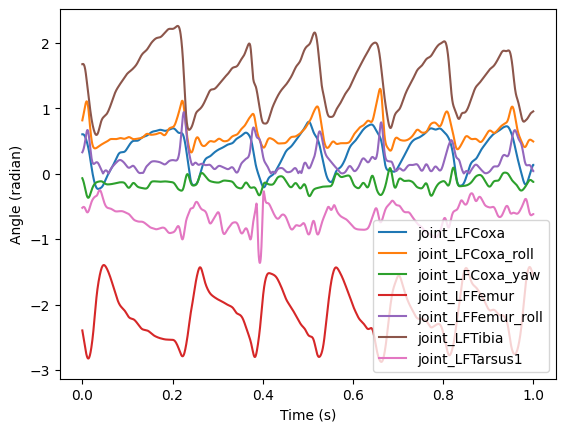

In [6]:
num_joints_to_visualize = 7
plt.plot(np.arange(data_block.shape[1]) * nmf.timestep,
         data_block[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')

Now, we're ready to run our simulation. Tip: this we can use `trange` from the [`tqdm` package](https://github.com/tqdm/tqdm) to add a progress bar. It works the same as Python's built-in `range`, but with a progress bar. You can also use `tqdm.tqdm` on a simple for-loop (without `range`).

In [ ]:
n_pts = 30
stifnesses =  np.logspace(-3, 1, n_pts)
n_pts_div2 = int(n_pts//2)
dampings = np.concatenate([np.logspace(-2, 0, n_pts_div2), np.linspace(0, 5, n_pts_div2)]) 
kps = np.linspace(0.5, 65, n_pts)
distances = np.zeros((n_pts, n_pts))

for i, damp in enumerate(dampings):
    for j, stif in enumerate(stifnesses):
        nmf = NeuroMechFlyMuJoCo(render_mode='headless',
                                    timestep=1e-4,
                                    render_config={'playspeed': 0.1, 'camera': 0},
                                    init_pose='stretch',
                                    actuated_joints=all_leg_dofs,
                                    floor_collisions_geoms="all",
                                    physics_config = {'joint_stiffness': stif,
                                                      'joint_damping': damp})
        obs_list = []
        print(f"Print round {i*n_pts+j} of {n_pts**2}, damp {damp}, stif {stif}")

        contact_forces = np.ones((len(nmf.collision_tracked_geoms), num_steps))*np.nan

        try:
            for k in range(num_steps):
                joint_pos = data_block[:, k]
                action = {'joints': joint_pos}
                obs, info = nmf.step(action)
                obs_list.append(obs)
                
                contact_forces[:, k] = obs['contact_forces'].copy()
                # if not touching the floor for the last 20 steps, break
                if np.all(contact_forces[:, k-20:k] <= 0 ) and k > 1000:
                    print(f"Not touching the floor, breaking {k/num_steps*100:.3}%", f"stifness {stif}, damping {damp}")
                    break

        except PhysicsError as pe:
            print("Physics error")
            distances[i, j] = np.nan

        plt.plot(contact_forces.T)
        plt.show()

        distances[i, j] = -1*(obs_list[0]["fly"][0][0] - obs_list[-1]["fly"][0][0])

In [ ]:
plt.imshow(distances)
plt.colorbar()
plt.xlabel("Stiffness")
plt.ylabel("Damping")
plt.xticks(np.arange(n_pts), np.round(stifnesses, 3))
plt.yticks(np.arange(n_pts), np.round(dampings, 3))
plt.show()

print(f"Max distance {np.max(distances)}")
i_max, j_max = np.unravel_index(np.argmax(distances), distances.shape)
print(f"Max distance at {stifnesses[i_max]}, {dampings[j_max]}")


In [ ]:

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                                timestep=1e-4,
                                render_config={'playspeed': 0.1, 'camera': 0},
                                init_pose='stretch',
                                actuated_joints=all_leg_dofs,
                                floor_collisions_geoms="all",
                                physics_config = {'joint_stiffness': stifnesses[j_max],
                                                  'joint_damping': dampings[i_max]})

# Run simulation
obs, info = nmf.reset()

obs_list = [obs]
for i in trange(num_steps):
    joint_pos = data_block[:, i]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

As before, we save and inspect the video:

In [ ]:
video_path = Path('kin_replay/video_stiff_damping_gridsearch_res.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

# Stifness and damping

Print round 0 of 100, kp 1.0, stif 0.0


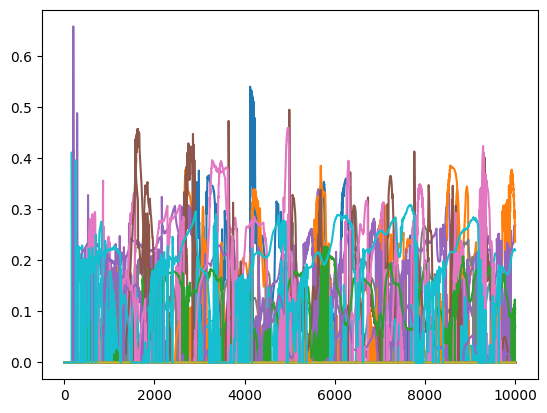

Print round 1 of 100, kp 1.0, stif 1.1111111111111112


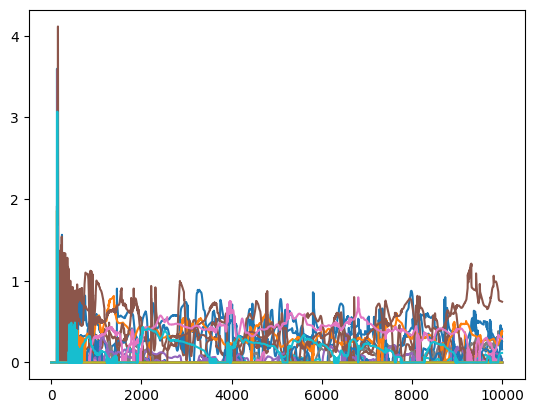

Print round 2 of 100, kp 1.0, stif 2.2222222222222223


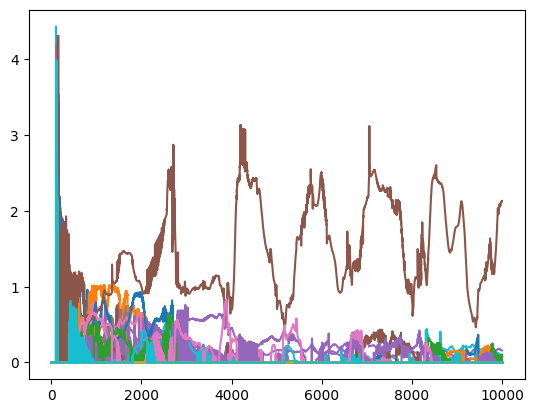

Print round 3 of 100, kp 1.0, stif 3.3333333333333335
Not touching the floor, breaking 13.2% stifness 3.3333333333333335, kp 1.0


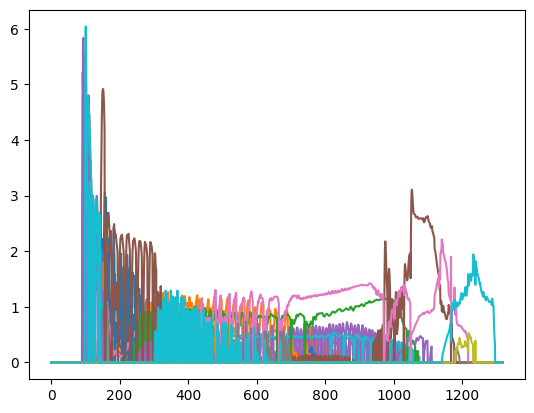

Print round 4 of 100, kp 1.0, stif 4.444444444444445
Not touching the floor, breaking 10.1% stifness 4.444444444444445, kp 1.0


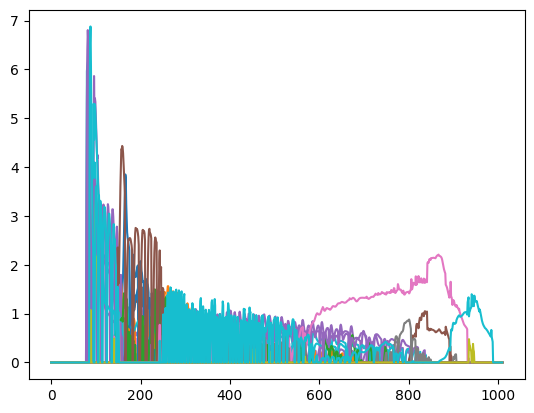

Print round 5 of 100, kp 1.0, stif 5.555555555555555
Not touching the floor, breaking 10.0% stifness 5.555555555555555, kp 1.0


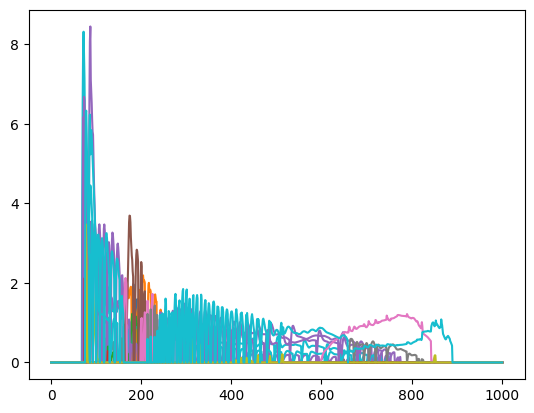

Print round 6 of 100, kp 1.0, stif 6.666666666666667
Not touching the floor, breaking 10.0% stifness 6.666666666666667, kp 1.0


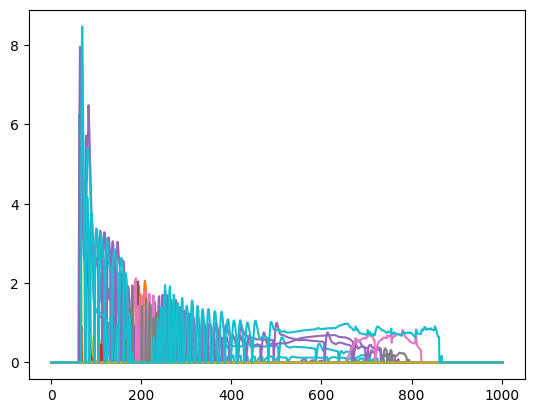

Print round 7 of 100, kp 1.0, stif 7.777777777777779
Not touching the floor, breaking 10.2% stifness 7.777777777777779, kp 1.0


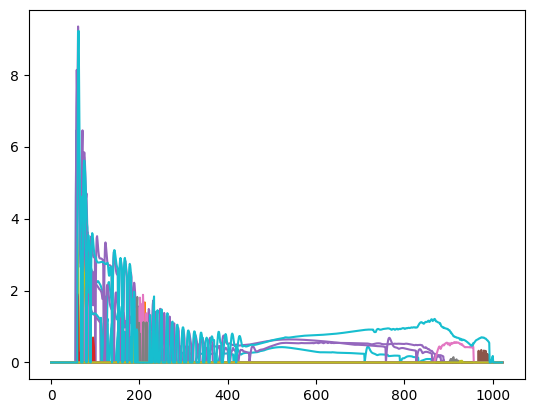

Print round 8 of 100, kp 1.0, stif 8.88888888888889
Not touching the floor, breaking 10.4% stifness 8.88888888888889, kp 1.0


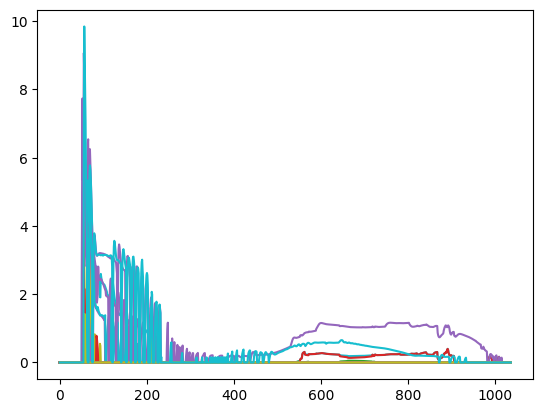

Print round 9 of 100, kp 1.0, stif 10.0
Not touching the floor, breaking 10.0% stifness 10.0, kp 1.0


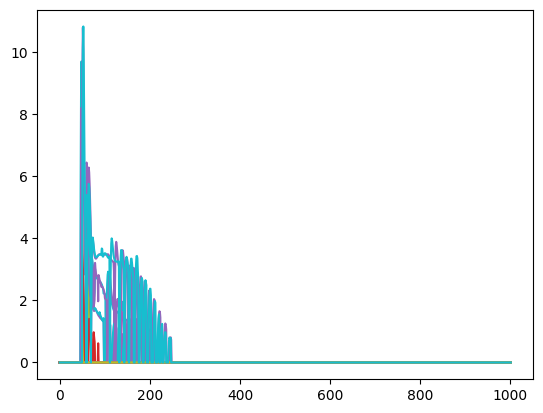

Print round 10 of 100, kp 7.555555555555555, stif 0.0


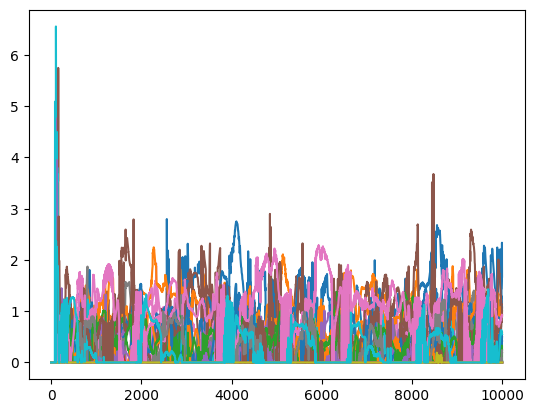

Print round 11 of 100, kp 7.555555555555555, stif 1.1111111111111112


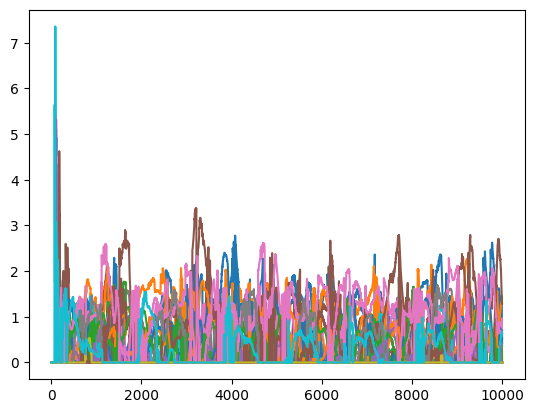

Print round 12 of 100, kp 7.555555555555555, stif 2.2222222222222223


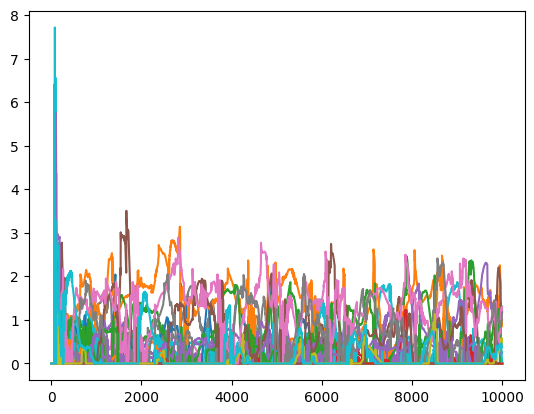

Print round 13 of 100, kp 7.555555555555555, stif 3.3333333333333335


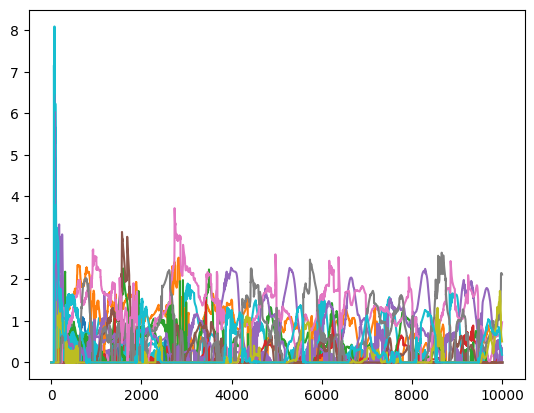

Print round 14 of 100, kp 7.555555555555555, stif 4.444444444444445
Not touching the floor, breaking 45.6% stifness 4.444444444444445, kp 7.555555555555555


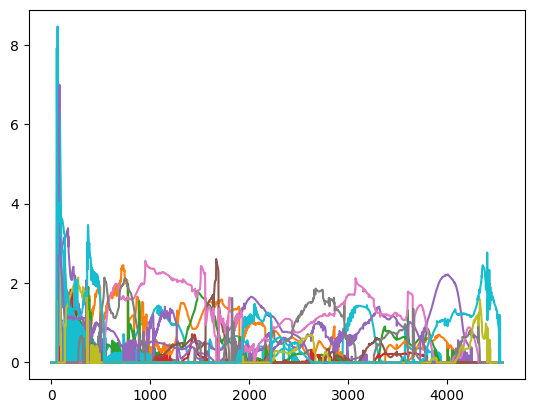

Print round 15 of 100, kp 7.555555555555555, stif 5.555555555555555
Not touching the floor, breaking 10.0% stifness 5.555555555555555, kp 7.555555555555555


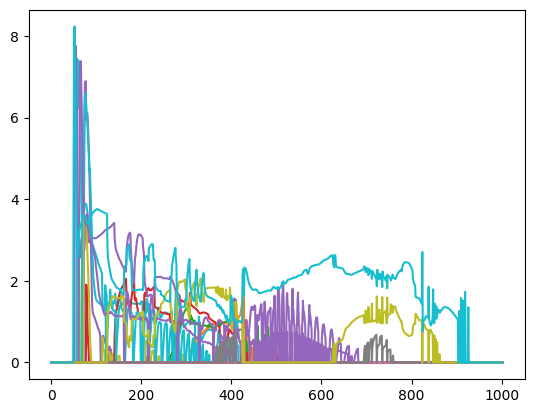

Print round 16 of 100, kp 7.555555555555555, stif 6.666666666666667
Not touching the floor, breaking 10.0% stifness 6.666666666666667, kp 7.555555555555555


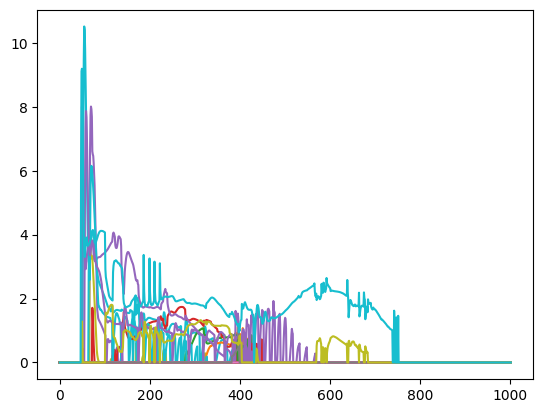

Print round 17 of 100, kp 7.555555555555555, stif 7.777777777777779
Not touching the floor, breaking 10.0% stifness 7.777777777777779, kp 7.555555555555555


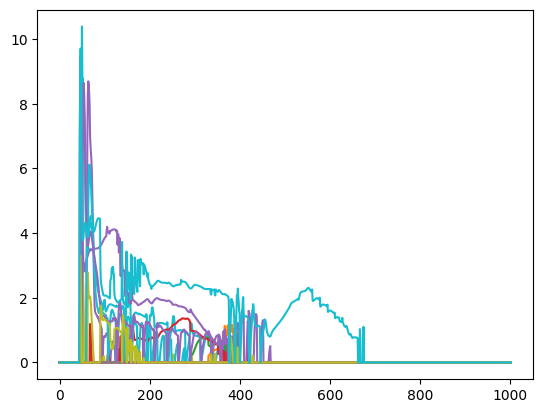

Print round 18 of 100, kp 7.555555555555555, stif 8.88888888888889
Not touching the floor, breaking 10.0% stifness 8.88888888888889, kp 7.555555555555555


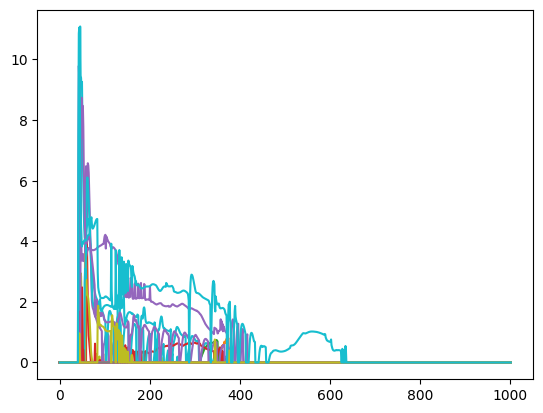

Print round 19 of 100, kp 7.555555555555555, stif 10.0
Not touching the floor, breaking 10.0% stifness 10.0, kp 7.555555555555555


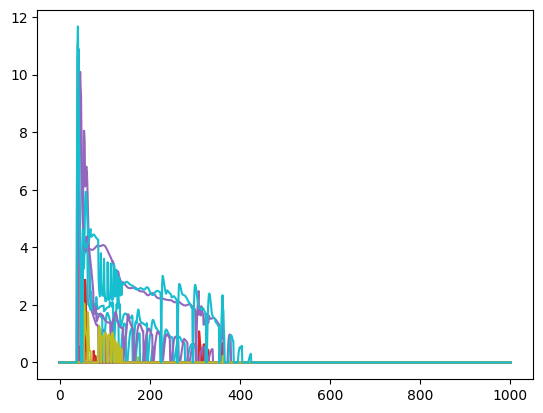

Print round 20 of 100, kp 14.11111111111111, stif 0.0


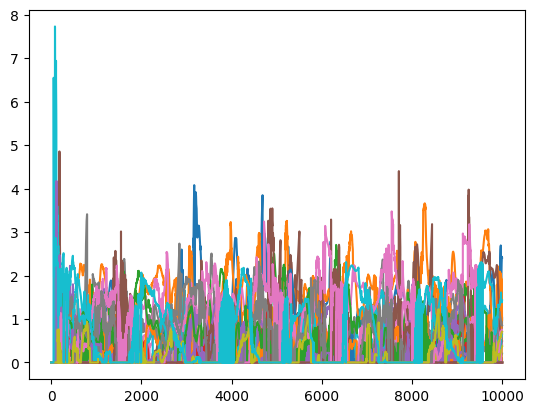

Print round 21 of 100, kp 14.11111111111111, stif 1.1111111111111112


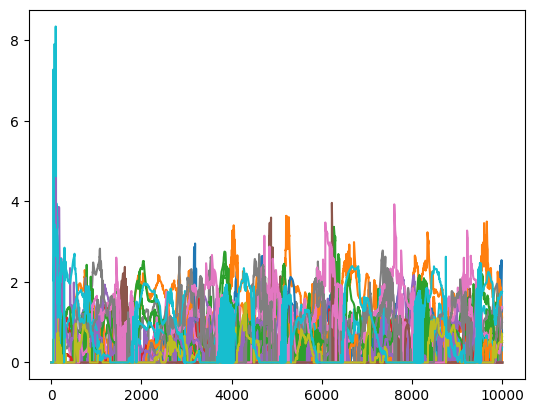

Print round 22 of 100, kp 14.11111111111111, stif 2.2222222222222223


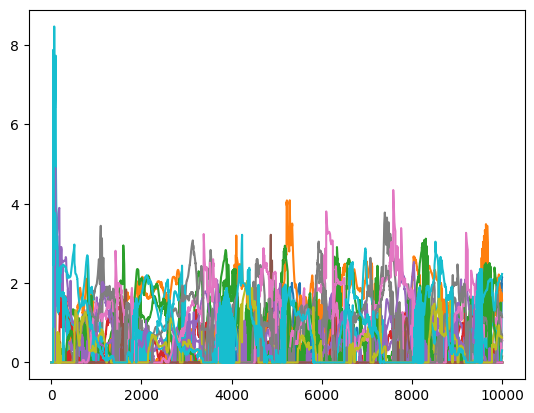

Print round 23 of 100, kp 14.11111111111111, stif 3.3333333333333335
Not touching the floor, breaking 89.1% stifness 3.3333333333333335, kp 14.11111111111111


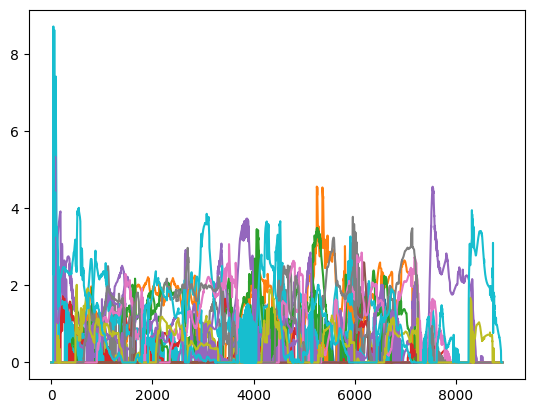

Print round 24 of 100, kp 14.11111111111111, stif 4.444444444444445
Not touching the floor, breaking 25.9% stifness 4.444444444444445, kp 14.11111111111111


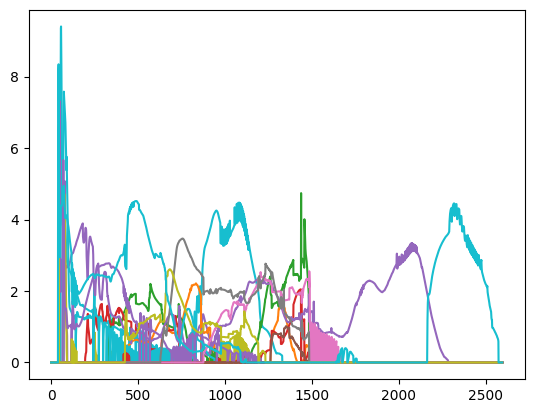

Print round 25 of 100, kp 14.11111111111111, stif 5.555555555555555
Not touching the floor, breaking 10.9% stifness 5.555555555555555, kp 14.11111111111111


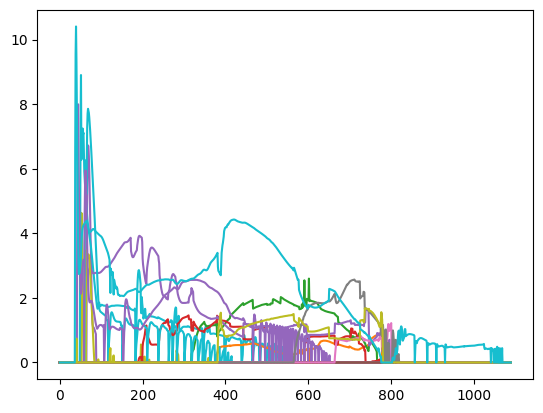

Print round 26 of 100, kp 14.11111111111111, stif 6.666666666666667
Not touching the floor, breaking 10.0% stifness 6.666666666666667, kp 14.11111111111111


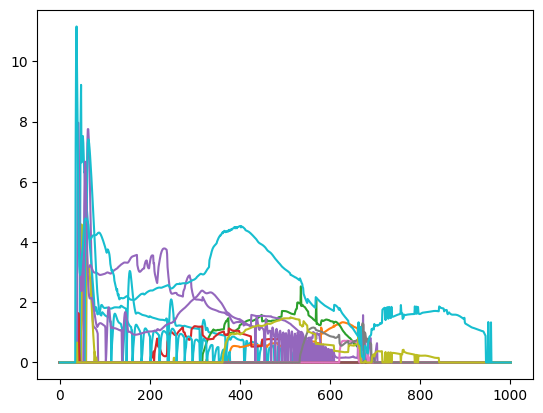

Print round 27 of 100, kp 14.11111111111111, stif 7.777777777777779
Not touching the floor, breaking 10.0% stifness 7.777777777777779, kp 14.11111111111111


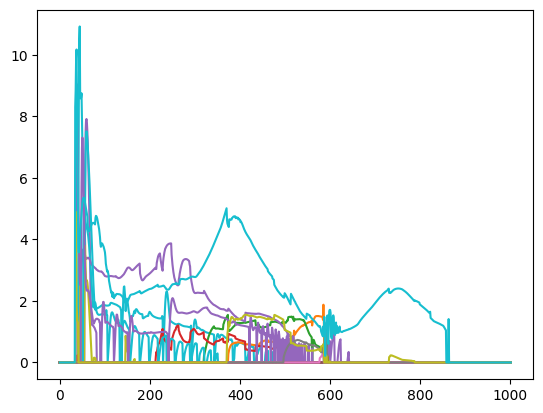

Print round 28 of 100, kp 14.11111111111111, stif 8.88888888888889
Not touching the floor, breaking 10.0% stifness 8.88888888888889, kp 14.11111111111111


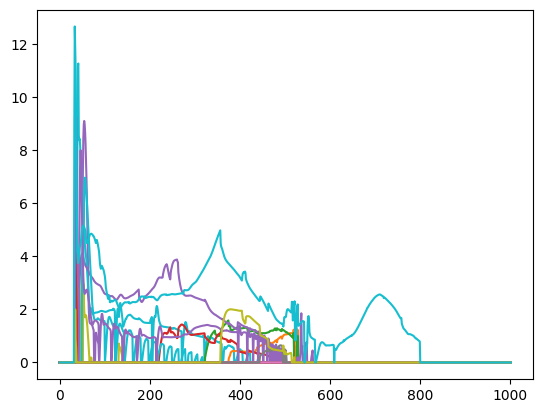

Print round 29 of 100, kp 14.11111111111111, stif 10.0
Not touching the floor, breaking 10.0% stifness 10.0, kp 14.11111111111111


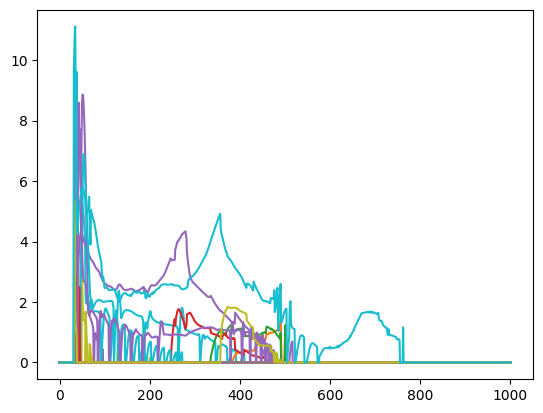

Print round 30 of 100, kp 20.666666666666664, stif 0.0


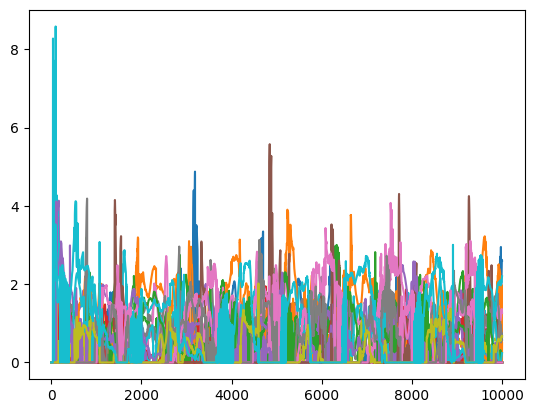

Print round 31 of 100, kp 20.666666666666664, stif 1.1111111111111112


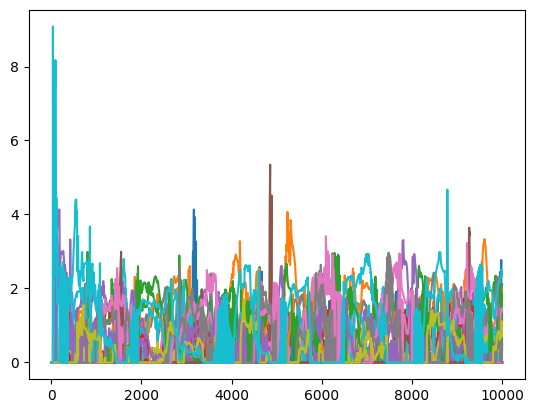

Print round 32 of 100, kp 20.666666666666664, stif 2.2222222222222223


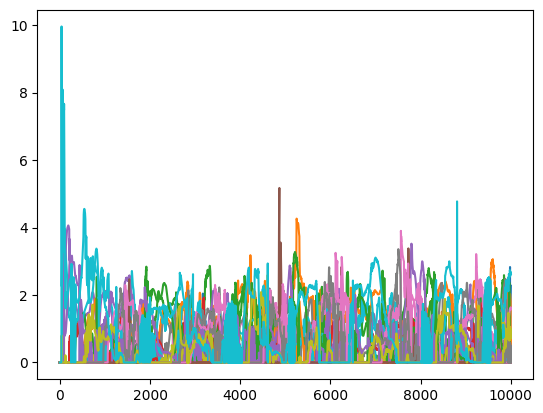

Print round 33 of 100, kp 20.666666666666664, stif 3.3333333333333335


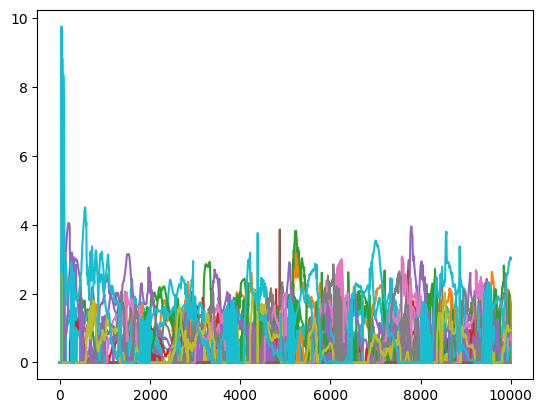

Print round 34 of 100, kp 20.666666666666664, stif 4.444444444444445


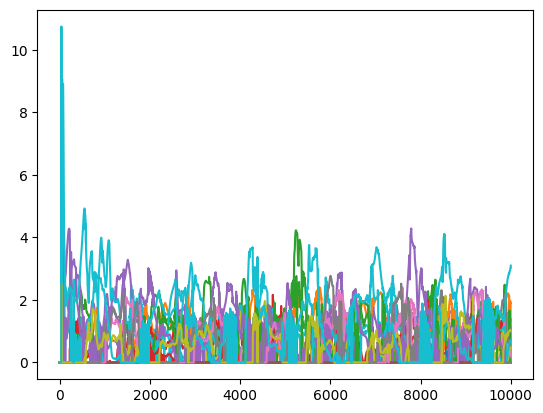

Print round 35 of 100, kp 20.666666666666664, stif 5.555555555555555
Not touching the floor, breaking 26.7% stifness 5.555555555555555, kp 20.666666666666664


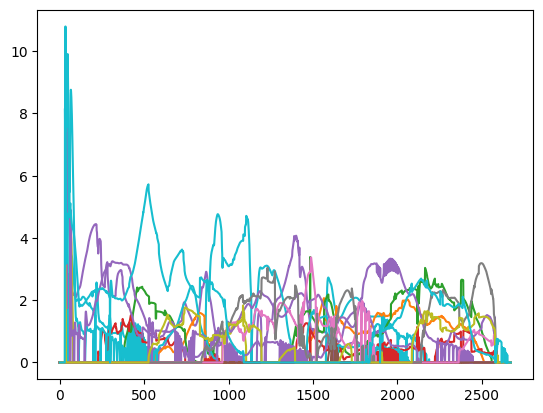

Print round 36 of 100, kp 20.666666666666664, stif 6.666666666666667
Not touching the floor, breaking 13.7% stifness 6.666666666666667, kp 20.666666666666664


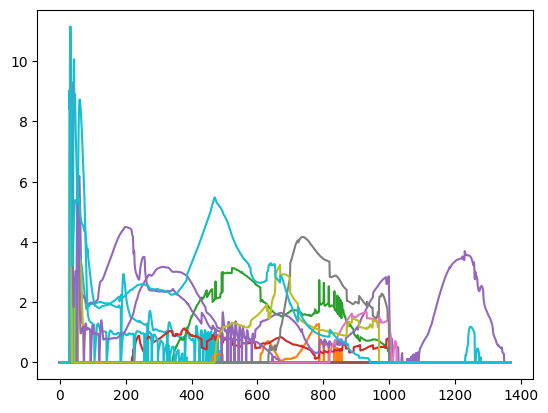

Print round 37 of 100, kp 20.666666666666664, stif 7.777777777777779
Not touching the floor, breaking 10.0% stifness 7.777777777777779, kp 20.666666666666664


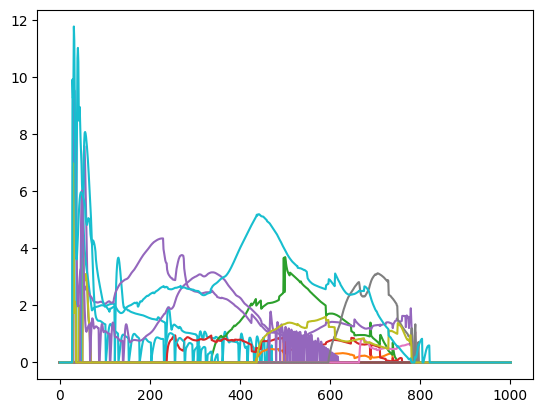

Print round 38 of 100, kp 20.666666666666664, stif 8.88888888888889
Not touching the floor, breaking 10.0% stifness 8.88888888888889, kp 20.666666666666664


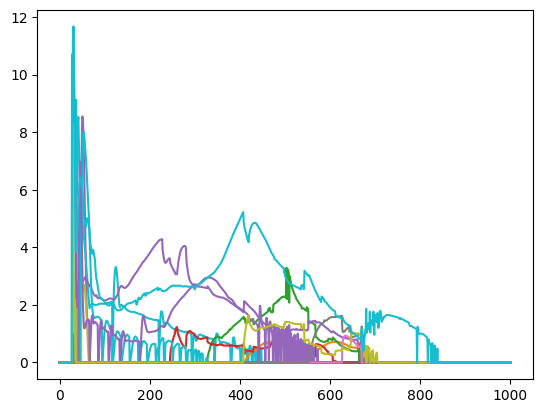

Print round 39 of 100, kp 20.666666666666664, stif 10.0
Not touching the floor, breaking 10.0% stifness 10.0, kp 20.666666666666664


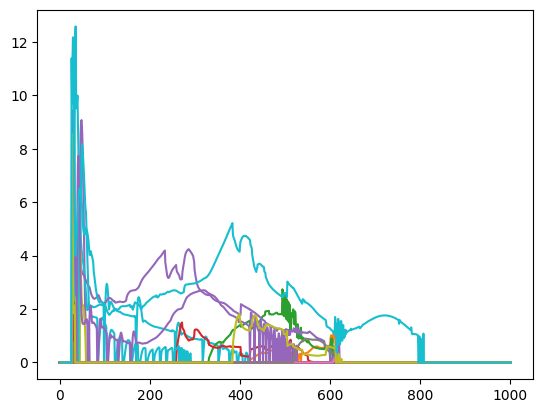

Print round 40 of 100, kp 27.22222222222222, stif 0.0


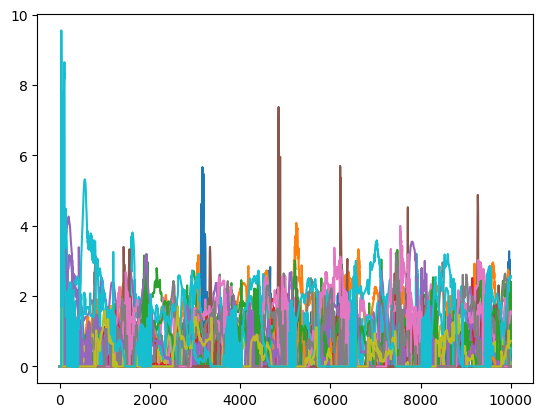

Print round 41 of 100, kp 27.22222222222222, stif 1.1111111111111112


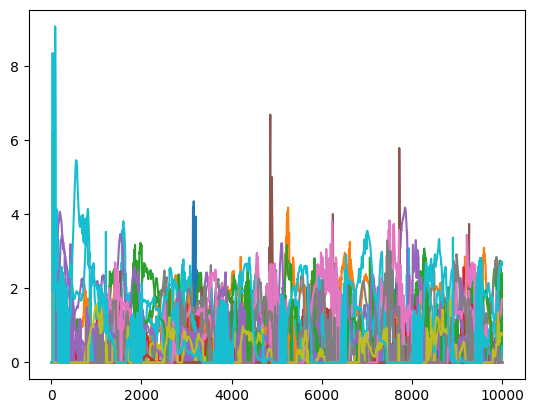

Print round 42 of 100, kp 27.22222222222222, stif 2.2222222222222223


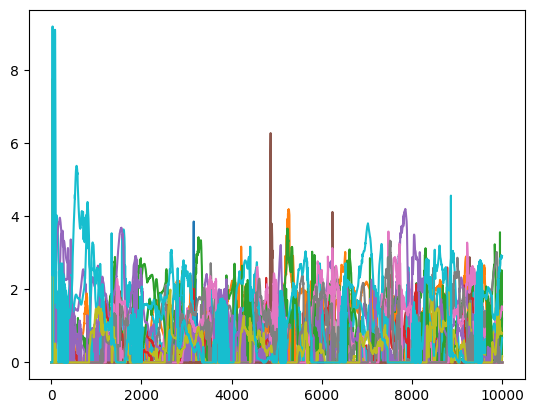

Print round 43 of 100, kp 27.22222222222222, stif 3.3333333333333335


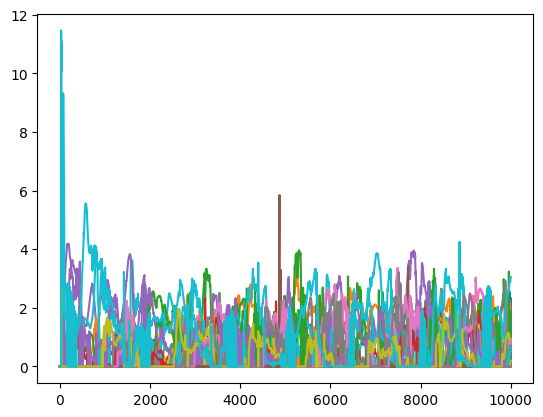

Print round 44 of 100, kp 27.22222222222222, stif 4.444444444444445


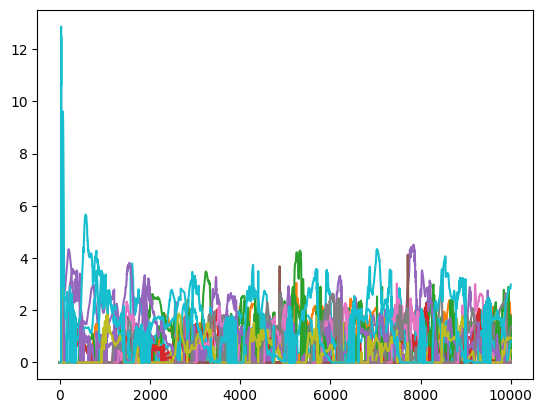

Print round 45 of 100, kp 27.22222222222222, stif 5.555555555555555


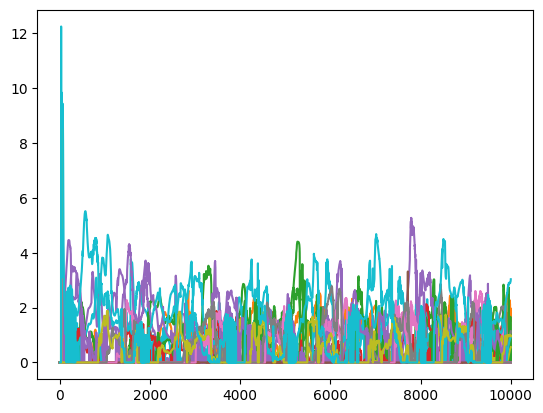

Print round 46 of 100, kp 27.22222222222222, stif 6.666666666666667


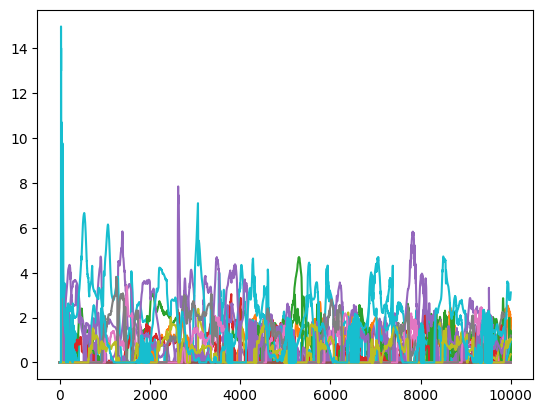

Print round 47 of 100, kp 27.22222222222222, stif 7.777777777777779
Not touching the floor, breaking 26.2% stifness 7.777777777777779, kp 27.22222222222222


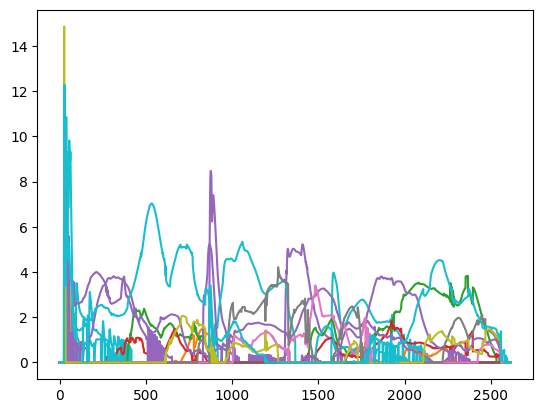

Print round 48 of 100, kp 27.22222222222222, stif 8.88888888888889
Not touching the floor, breaking 10.0% stifness 8.88888888888889, kp 27.22222222222222


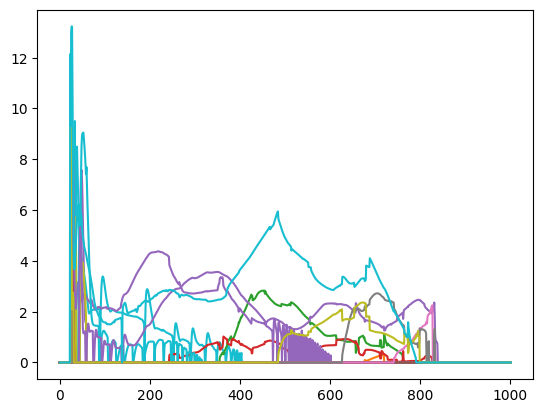

Print round 49 of 100, kp 27.22222222222222, stif 10.0
Not touching the floor, breaking 10.0% stifness 10.0, kp 27.22222222222222


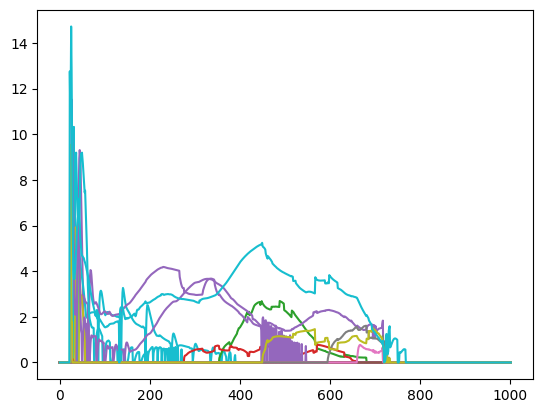

Print round 50 of 100, kp 33.77777777777778, stif 0.0


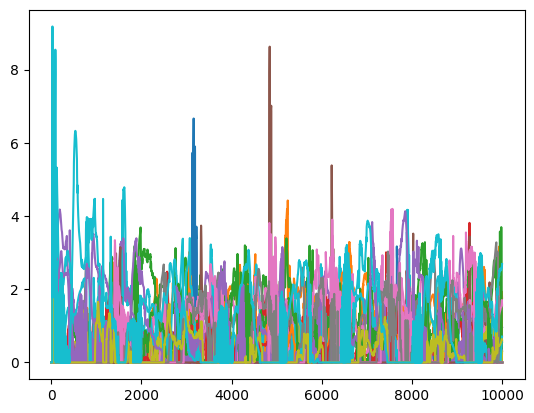

Print round 51 of 100, kp 33.77777777777778, stif 1.1111111111111112


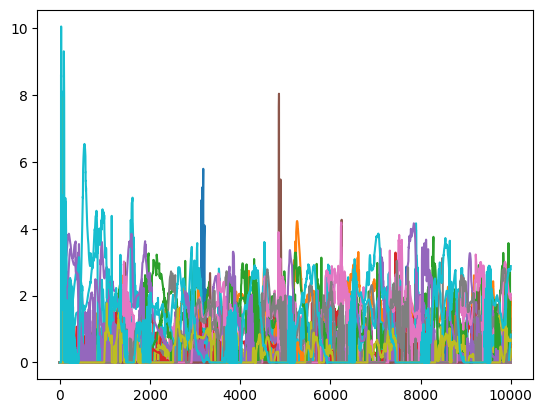

Print round 52 of 100, kp 33.77777777777778, stif 2.2222222222222223


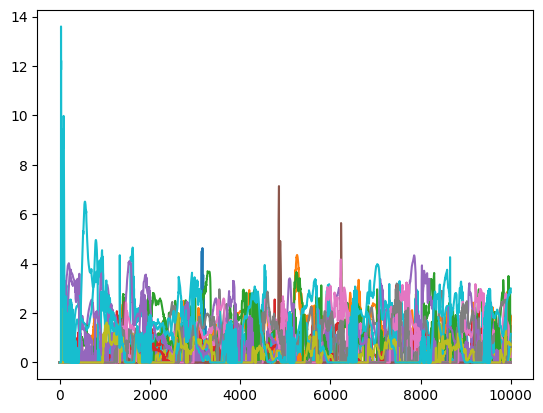

Print round 53 of 100, kp 33.77777777777778, stif 3.3333333333333335


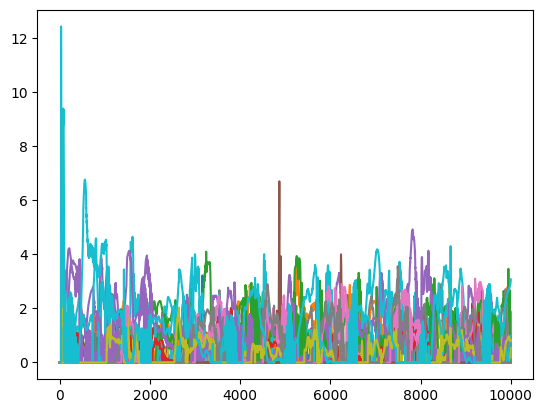

Print round 54 of 100, kp 33.77777777777778, stif 4.444444444444445


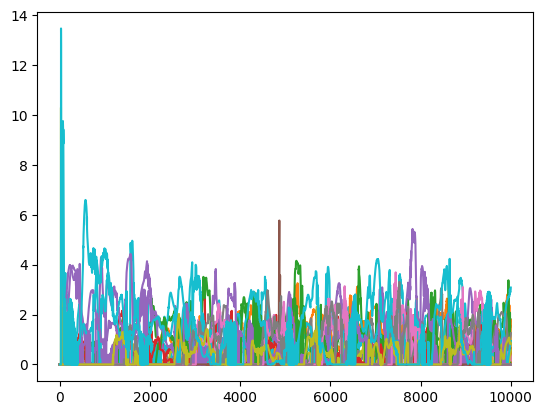

Print round 55 of 100, kp 33.77777777777778, stif 5.555555555555555


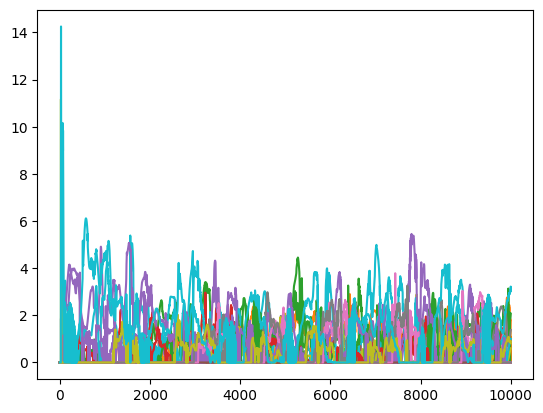

Print round 56 of 100, kp 33.77777777777778, stif 6.666666666666667


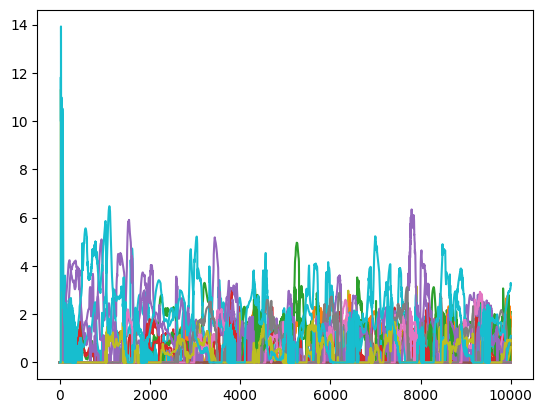

Print round 57 of 100, kp 33.77777777777778, stif 7.777777777777779


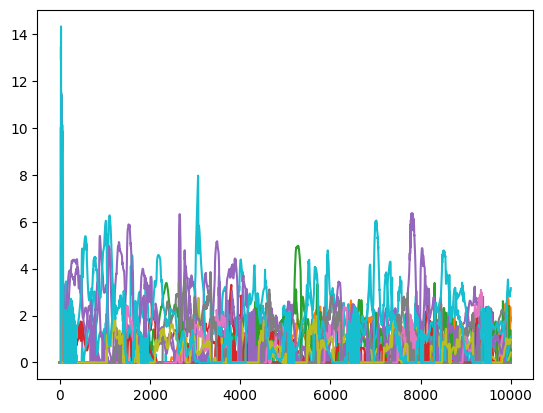

Print round 58 of 100, kp 33.77777777777778, stif 8.88888888888889
Not touching the floor, breaking 25.5% stifness 8.88888888888889, kp 33.77777777777778


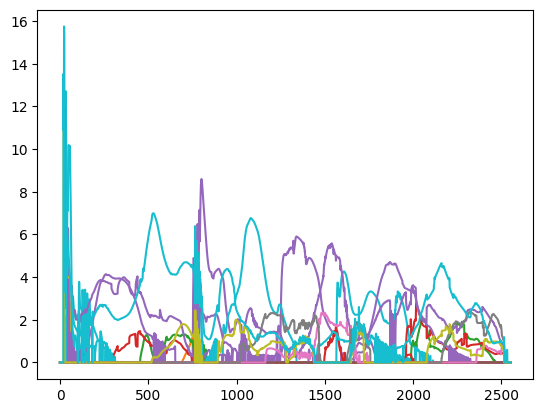

Print round 59 of 100, kp 33.77777777777778, stif 10.0
Not touching the floor, breaking 24.5% stifness 10.0, kp 33.77777777777778


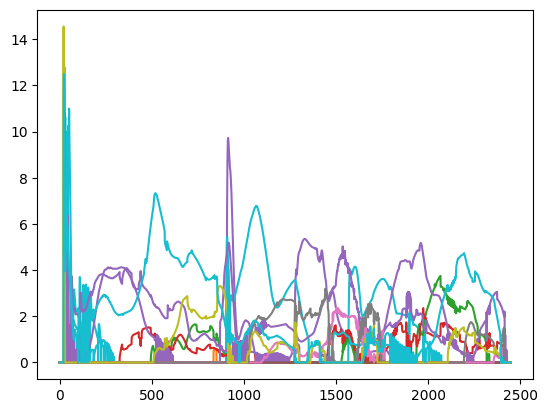

Print round 60 of 100, kp 40.33333333333333, stif 0.0


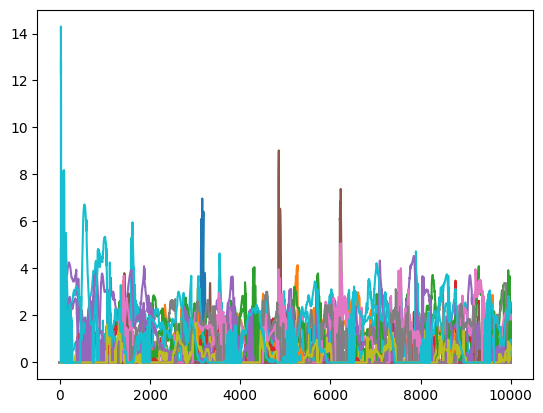

Print round 61 of 100, kp 40.33333333333333, stif 1.1111111111111112


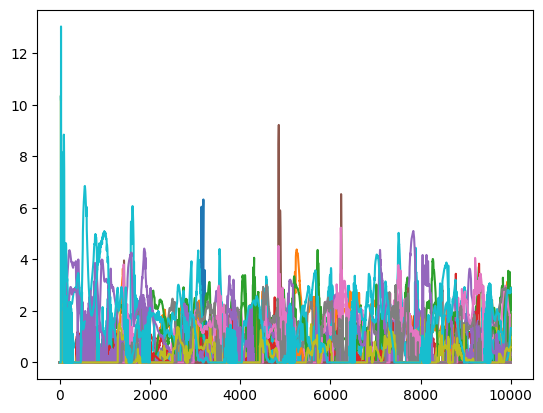

Print round 62 of 100, kp 40.33333333333333, stif 2.2222222222222223


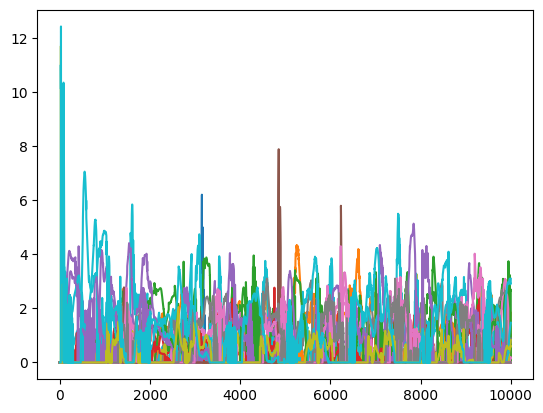

Print round 63 of 100, kp 40.33333333333333, stif 3.3333333333333335


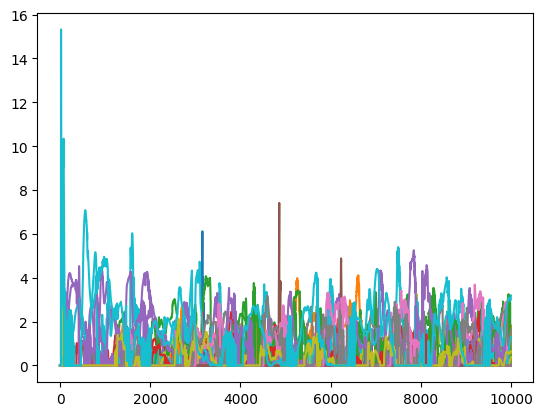

Print round 64 of 100, kp 40.33333333333333, stif 4.444444444444445


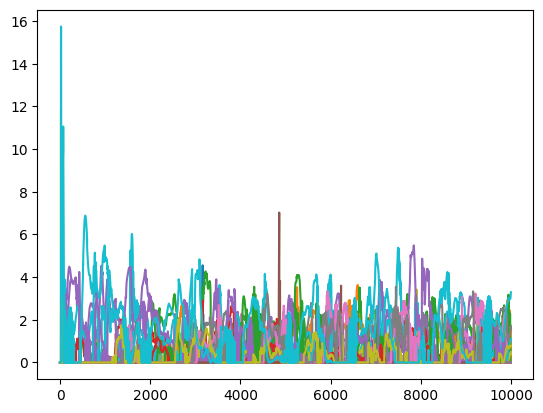

Print round 65 of 100, kp 40.33333333333333, stif 5.555555555555555


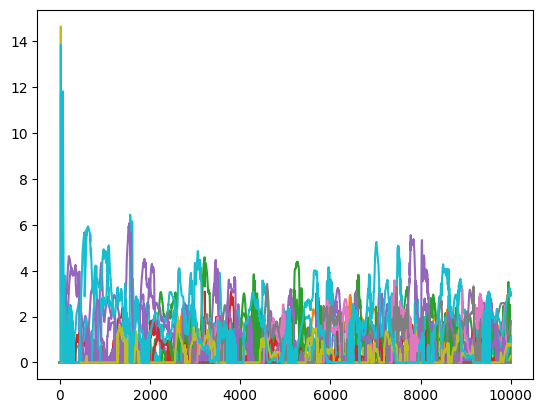

Print round 66 of 100, kp 40.33333333333333, stif 6.666666666666667


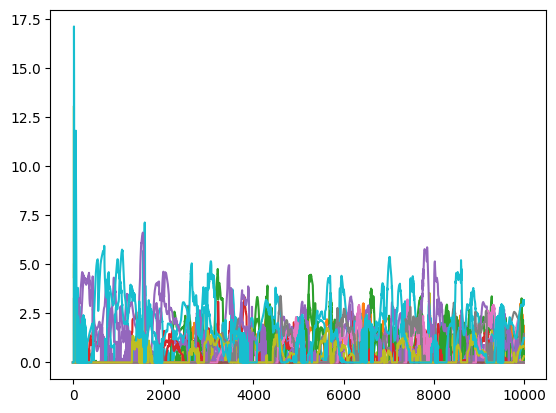

Print round 67 of 100, kp 40.33333333333333, stif 7.777777777777779


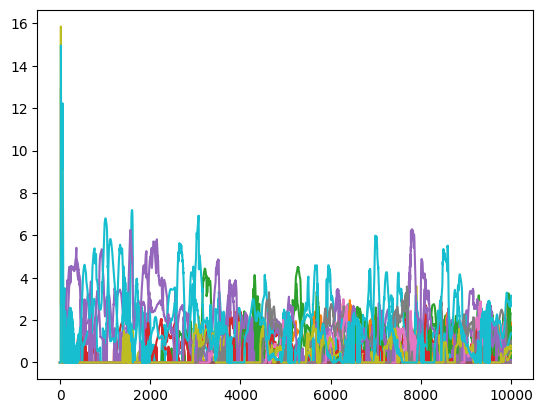

Print round 68 of 100, kp 40.33333333333333, stif 8.88888888888889


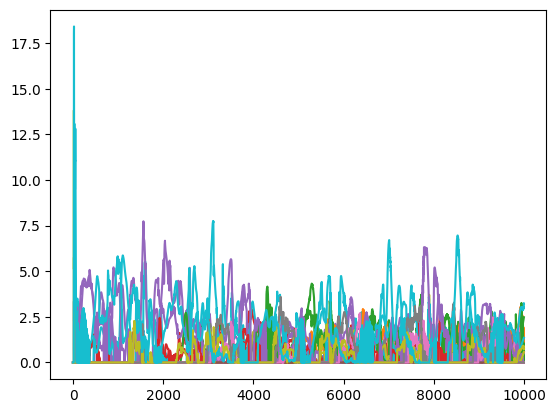

Print round 69 of 100, kp 40.33333333333333, stif 10.0


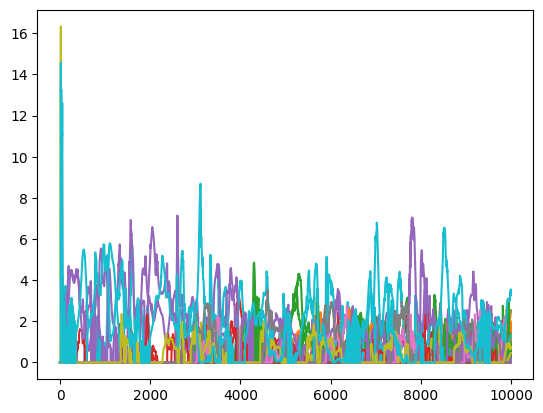

Print round 70 of 100, kp 46.888888888888886, stif 0.0


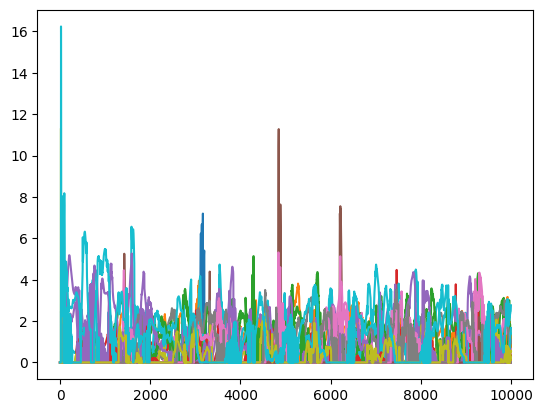

Print round 71 of 100, kp 46.888888888888886, stif 1.1111111111111112


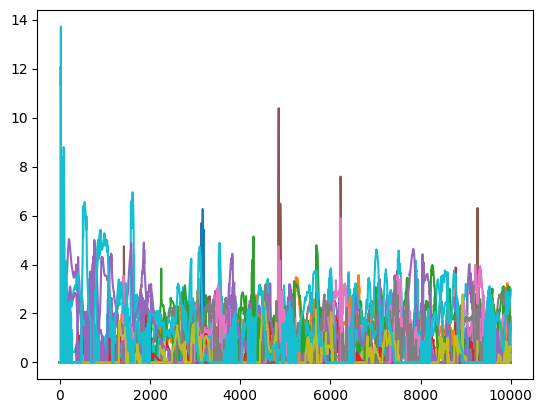

Print round 72 of 100, kp 46.888888888888886, stif 2.2222222222222223


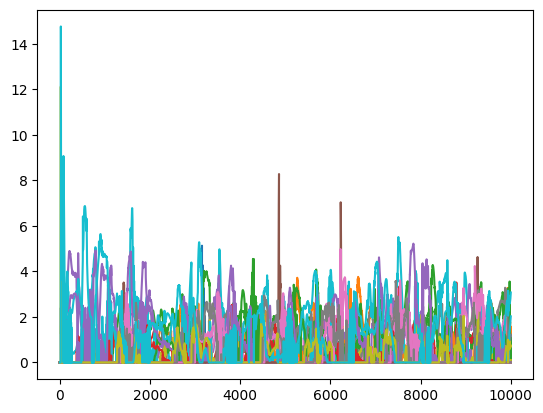

Print round 73 of 100, kp 46.888888888888886, stif 3.3333333333333335


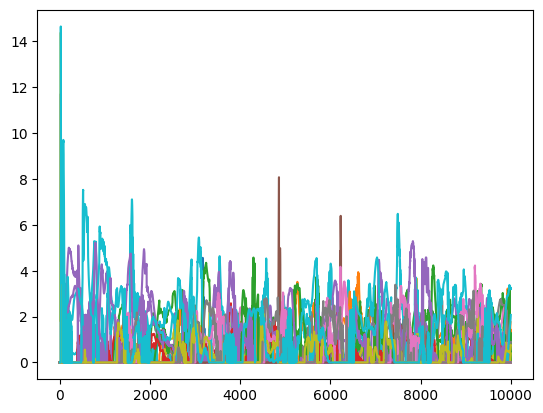

Print round 74 of 100, kp 46.888888888888886, stif 4.444444444444445


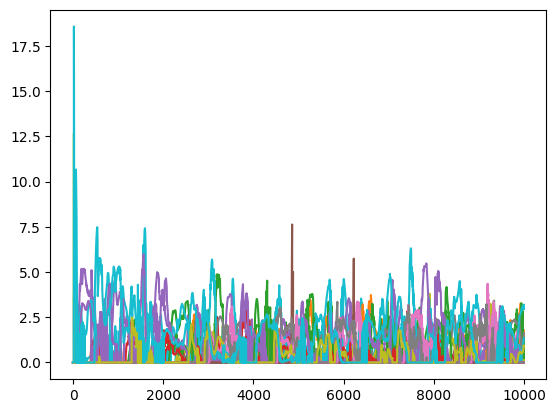

Print round 75 of 100, kp 46.888888888888886, stif 5.555555555555555


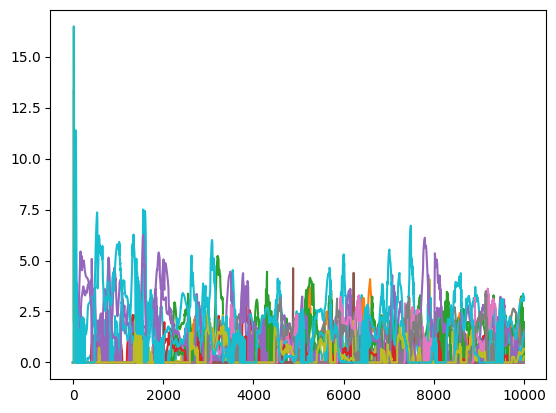

Print round 76 of 100, kp 46.888888888888886, stif 6.666666666666667


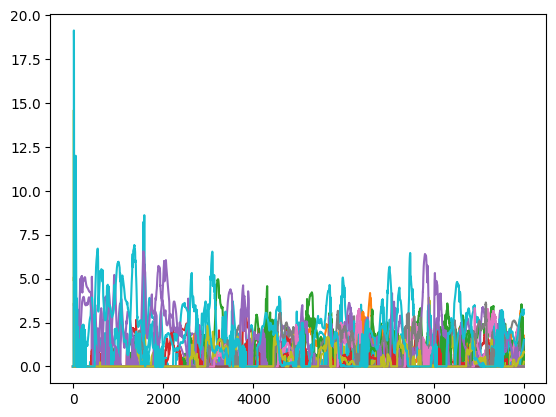

Print round 77 of 100, kp 46.888888888888886, stif 7.777777777777779


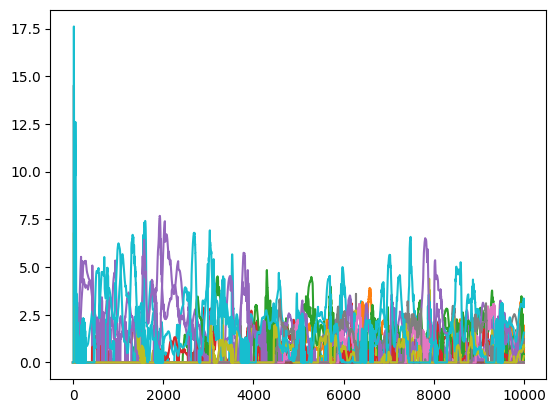

Print round 78 of 100, kp 46.888888888888886, stif 8.88888888888889


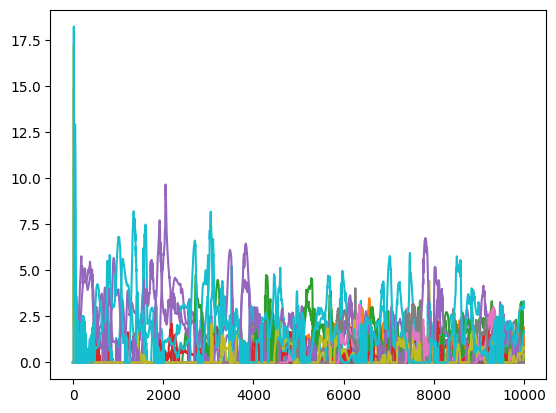

Print round 79 of 100, kp 46.888888888888886, stif 10.0


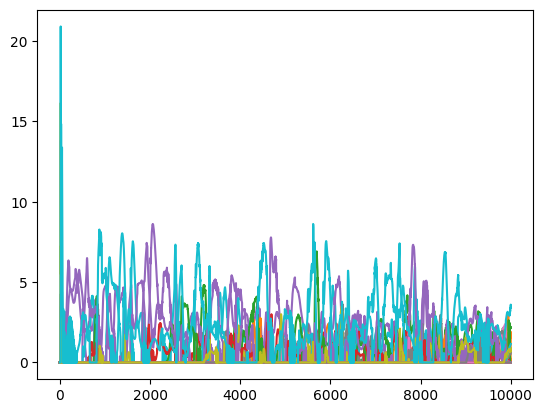

Print round 80 of 100, kp 53.44444444444444, stif 0.0


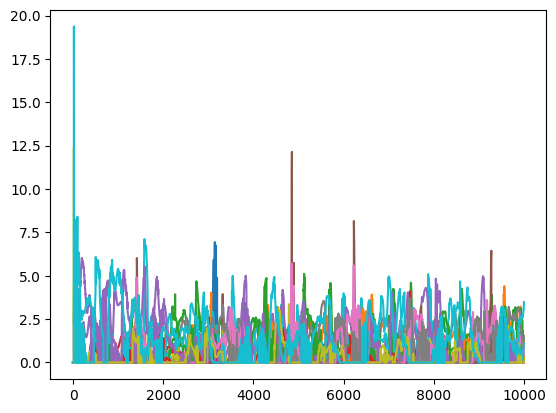

Print round 81 of 100, kp 53.44444444444444, stif 1.1111111111111112


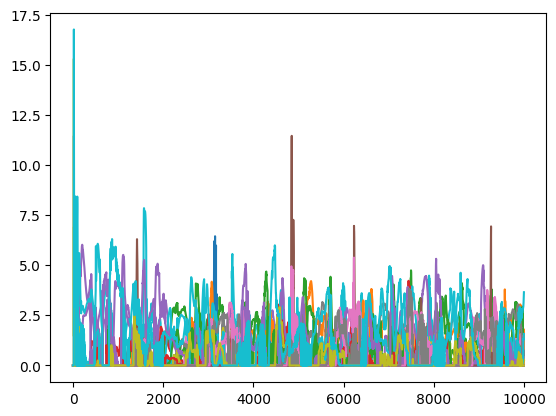

Print round 82 of 100, kp 53.44444444444444, stif 2.2222222222222223


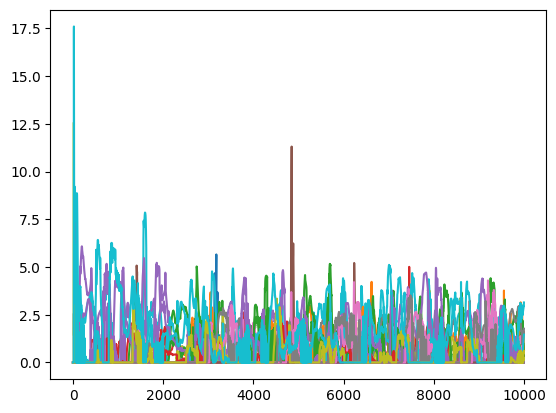

Print round 83 of 100, kp 53.44444444444444, stif 3.3333333333333335


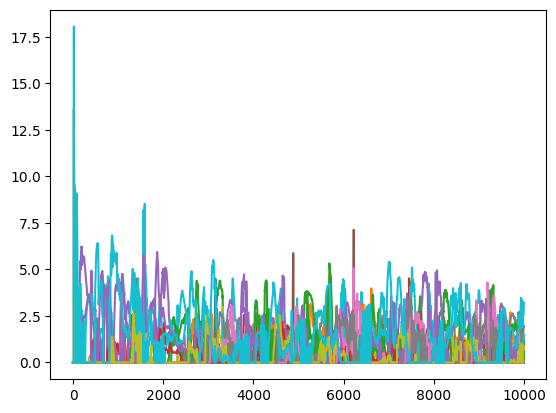

Print round 84 of 100, kp 53.44444444444444, stif 4.444444444444445


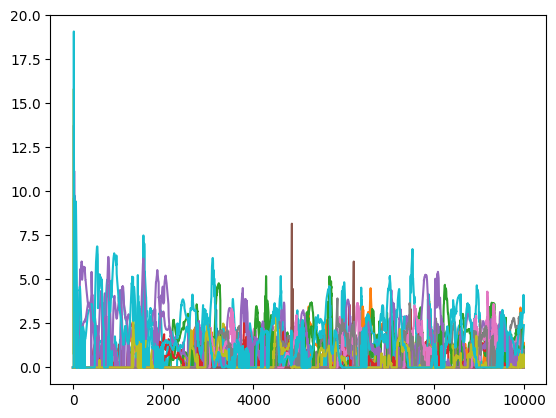

Print round 85 of 100, kp 53.44444444444444, stif 5.555555555555555


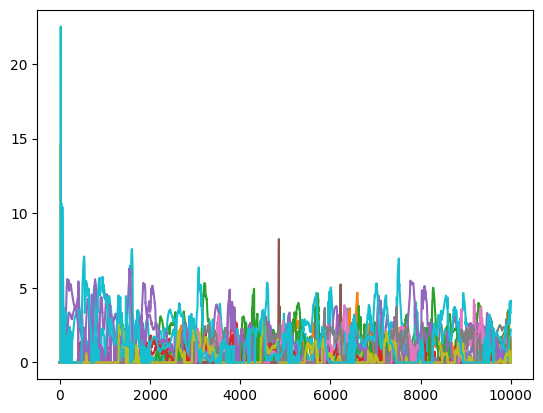

Print round 86 of 100, kp 53.44444444444444, stif 6.666666666666667


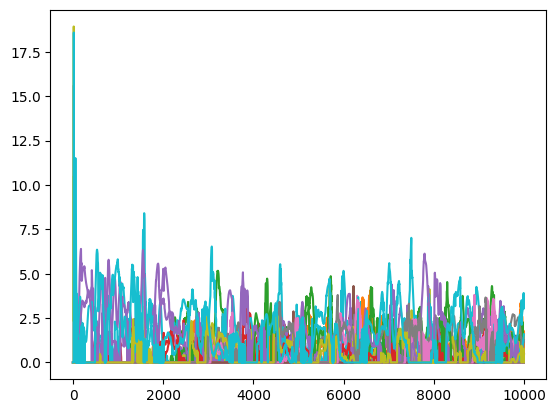

Print round 87 of 100, kp 53.44444444444444, stif 7.777777777777779


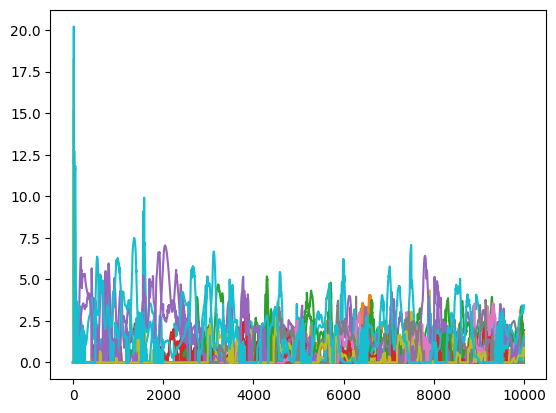

Print round 88 of 100, kp 53.44444444444444, stif 8.88888888888889


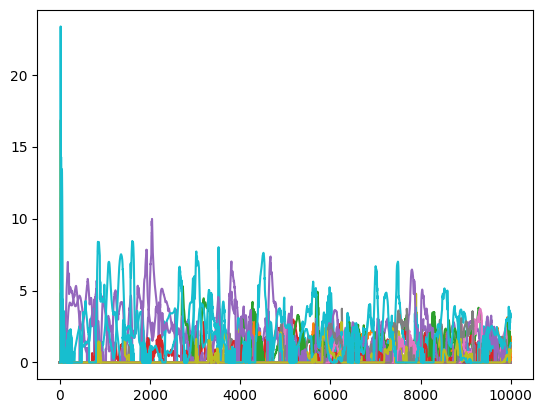

Print round 89 of 100, kp 53.44444444444444, stif 10.0


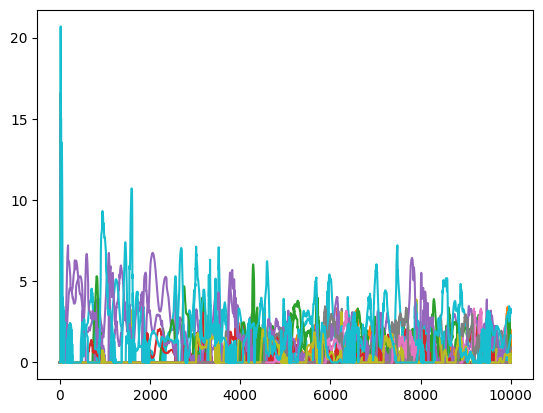

Print round 90 of 100, kp 60.0, stif 0.0


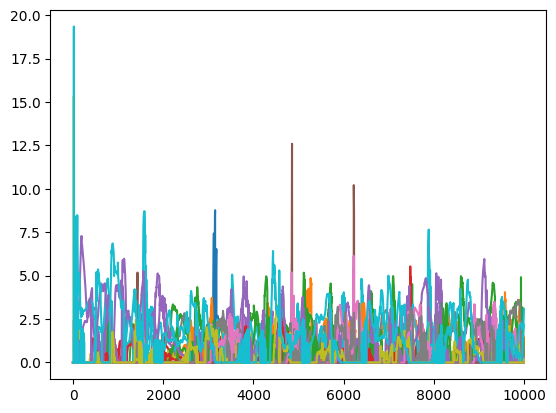

Print round 91 of 100, kp 60.0, stif 1.1111111111111112


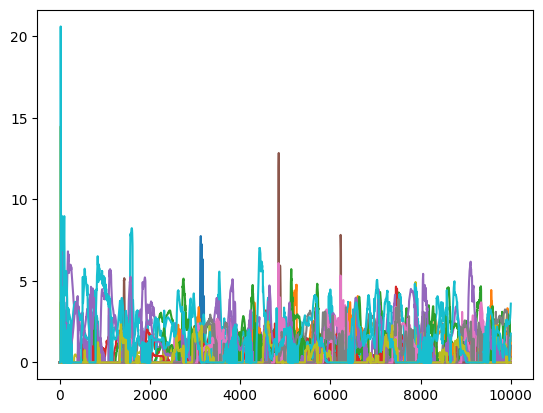

Print round 92 of 100, kp 60.0, stif 2.2222222222222223


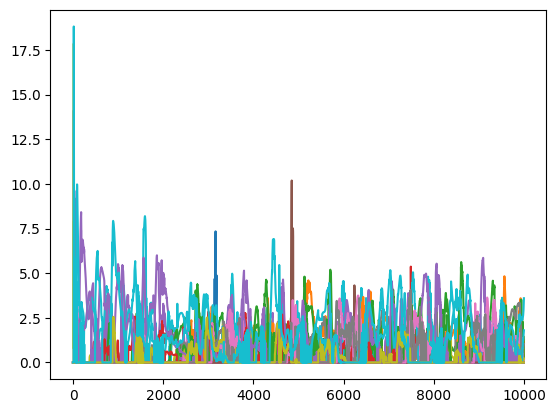

Print round 93 of 100, kp 60.0, stif 3.3333333333333335


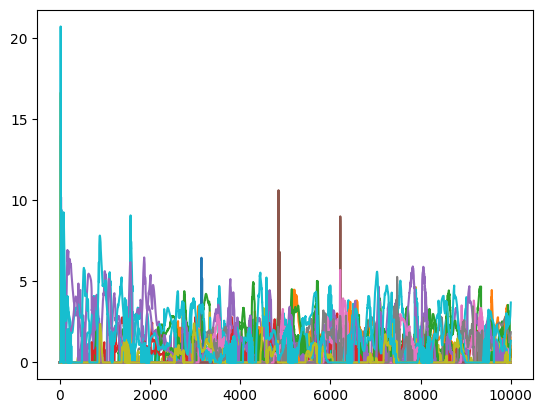

Print round 94 of 100, kp 60.0, stif 4.444444444444445


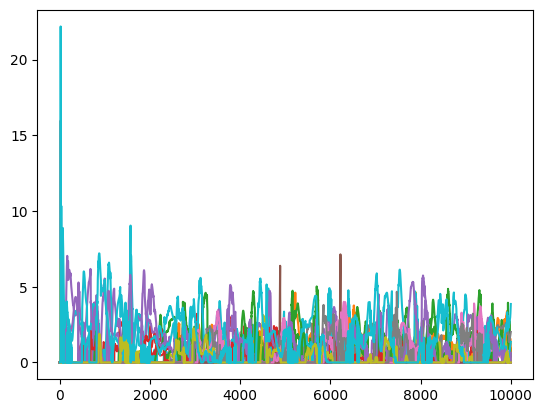

Print round 95 of 100, kp 60.0, stif 5.555555555555555


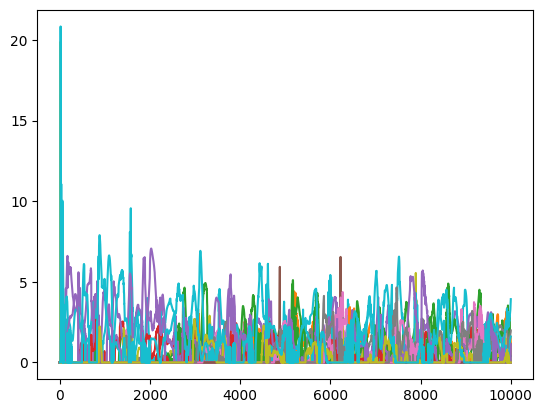

Print round 96 of 100, kp 60.0, stif 6.666666666666667


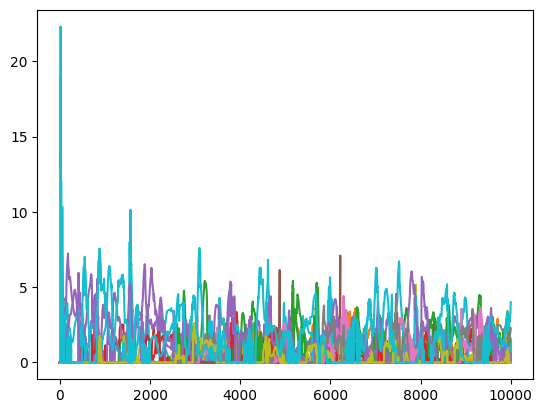

Print round 97 of 100, kp 60.0, stif 7.777777777777779


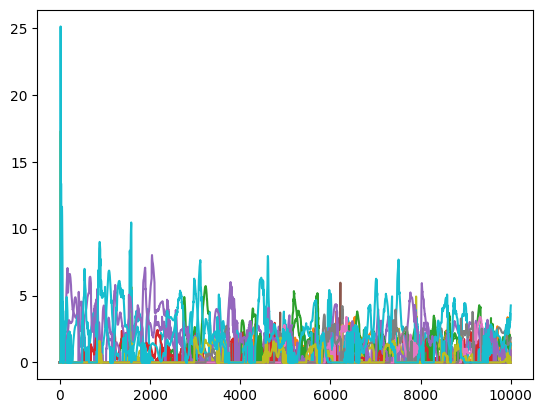

Print round 98 of 100, kp 60.0, stif 8.88888888888889


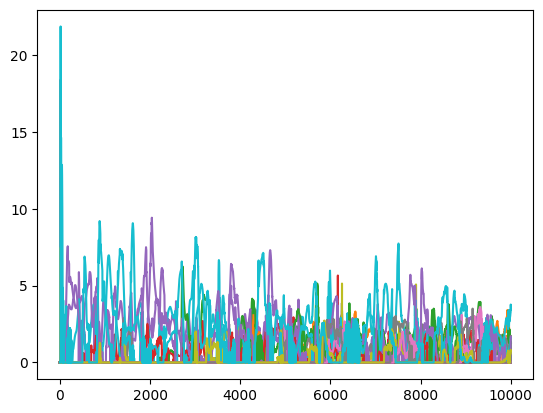

Print round 99 of 100, kp 60.0, stif 10.0


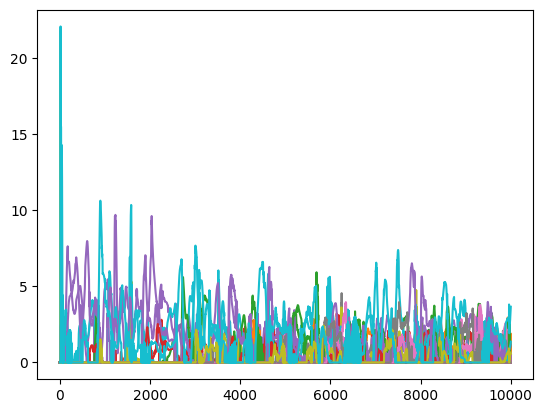

In [31]:
n_pts = 10
stifnesses =  np.linspace(0, 10, n_pts)
n_pts_div2 = int(n_pts//2)
kps = np.linspace(1, 60, n_pts)
distances = np.zeros((n_pts, n_pts))

for i, kp in enumerate(kps):
    for j, stif in enumerate(stifnesses):
        nmf = NeuroMechFlyMuJoCo(render_mode='headless',
                                    timestep=1e-4,
                                    render_config={'playspeed': 0.1, 'camera': 0},
                                    init_pose='stretch',
                                    actuated_joints=all_leg_dofs,
                                    floor_collisions_geoms="all",
                                    physics_config = {'joint_stiffness': stif,
                                                      'actuator_kp': kp})
        obs_list = []
        print(f"Print round {i*n_pts+j} of {n_pts**2}, kp {kp}, stif {stif}")

        contact_forces = np.ones((len(nmf.collision_tracked_geoms), num_steps))*np.nan

        try:
            for k in range(num_steps):
                joint_pos = data_block[:, k]
                action = {'joints': joint_pos}
                obs, info = nmf.step(action)
                obs_list.append(obs)
                
                contact_forces[:, k] = obs['contact_forces'].copy()
                # if not touching the floor for the last 20 steps, break
                if np.all(contact_forces[:, k-20:k] <= 0 ) and k > 1000:
                    print(f"Not touching the floor, breaking {k/num_steps*100:.3}%", f"stifness {stif}, kp {kp}")
                    break

        except PhysicsError as pe:
            print("Physics error")
            distances[i, j] = np.nan
        else:
            distances[i, j] = -1*(obs_list[0]["fly"][0][0] - obs_list[-1]["fly"][0][0])
        plt.plot(contact_forces.T)
        plt.show()

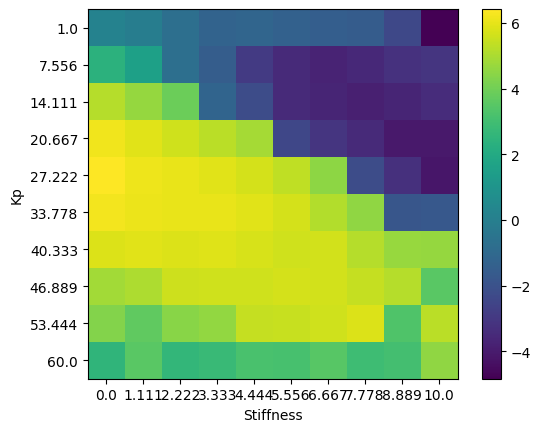

Max distance 6.420967522391326
Max distance at 0.0, 27.22222222222222


In [35]:
plt.imshow(distances)
plt.colorbar()
plt.xlabel("Stiffness")
plt.ylabel("Kp")
plt.xticks(np.arange(n_pts), np.round(stifnesses, 3), rotation=90)
plt.yticks(np.arange(n_pts), np.round(kps, 3))
plt.show()

print(f"Max distance {np.nanmax(distances)}")
i_max, j_max = np.unravel_index(np.nanargmax(distances), distances.shape)
print(f"Max distance at {stifnesses[j_max]}, {kps[i_max]}")

In [33]:
nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                                timestep=1e-4,
                                render_config={'playspeed': 0.1, 'camera': 0},
                                init_pose='stretch',
                                actuated_joints=all_leg_dofs,
                                floor_collisions_geoms="all",
                                physics_config = {'joint_stiffness': stifnesses[j_max],
                                                  'actuator_kp': kps[i_max]})

# Run simulation
obs, info = nmf.reset()

obs_list = [obs]
for i in trange(num_steps):
    joint_pos = data_block[:, i]
    action = {'joints': joint_pos}
    obs, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [00:31<00:00, 321.09it/s]


In [34]:
video_path = Path('kin_replay/video_stiff_kp_gridsearch_res.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

As previously explained, the on-the-ball walking behavior is not entirely realistic when released on the floor. Nonetheless, this serves as a proof-of-concept.